# PHYS 5020 - Image Registration and Segmentation

## Assignment Worksheet

This jupyter notebook contains useful pieces of documented python code.

Please feel free to use, adapt, and extend this code in your assignment.

You are encouraged to add to this notebook!

### Links
To download and check out platipy: https://github.com/pyplati/platipy

You should check out the examples: https://github.com/pyplati/platipy/tree/master/examples

Documentation available here: https://pyplati.github.io/platipy/


### Authors:
Dr Rob Finnegan

Dr John Kipritidis

### Student information:

#### Name:
Fidel Alejandro Navarro Salazar

#### Student number:
520176832

#### Date:
17/10/2022

In [1]:
# set-up
# IMPORTANT - IF YOU ARE USING GOOGLE COLAB MAKE SURE TO RESTART RUNTIME!

try:
    import platipy
except ImportError:
    !pip install platipy

In [2]:
#!pip install matplotlib==3.2.2 --user

In [3]:
# import some basic modules

from platipy.imaging import ImageVisualiser

import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

C:\Users\fidel\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\fidel\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\fidel\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
# download the assignment data

#!gdown 1R6VbCJ7xUxF5PvoGLbBKSvIC_ZGKcyhe --output data.zip

In [5]:
# unzip the data
# you can change the output location if you want

#!unzip ./data.zip > /dev/null

***
# Task 1 
## Automatic bone segmentation on CT scans 

Segmentation of bones can be used to assess patient set-up, which is relevant for radiotherapy treatment. 

This task can be accomplished with simple methods because the x-ray attenuation of bones is much greater than that of soft tissues, and so the image intensity values are much higher for bone than other soft tissues.



As a medical physics registrar, you have been provided with two CT scans from the same patient, one of the head and neck region (HN) and one of the body (from the neck to mid-thigh).

### Question 1

Generate a histogram of image intensity values using the HN scan.

Include on your axes the physical units used to measure CT image values.

In [6]:
# read in the HN CT scan

img_ct_hn = sitk.ReadImage("./data/task_1/HN_CT.nii.gz")

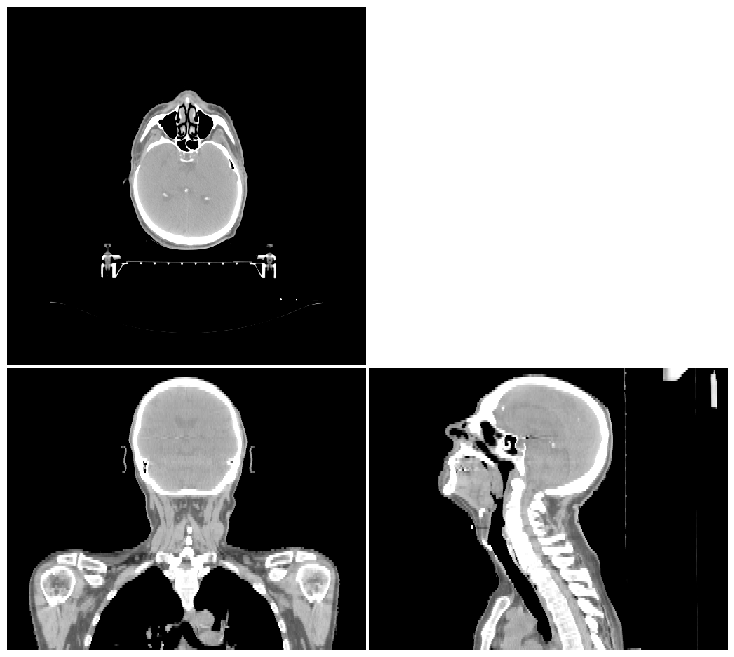

In [7]:
# visualise the image
vis = ImageVisualiser(
    image = img_ct_hn,
    cut = (95,256,256),         # the (axial, coronal, sagittal) slice location
    axis = 'ortho',             # this can be "z (axial)", "y (corornal)", "x (sagittal)", "ortho"
    window = (-250, 500),       # specify as (min, range)
    figure_size_in = 10,         # the size of the image
    colormap = plt.cm.Greys_r,  # color map, see: https://matplotlib.org/stable/tutorials/colors/colormaps.html
    projection = False,         # type of intensity projection: "max" (MIP), "mean", "median", etc.
)
    
# create the figure
fig = vis.show()

In [8]:
# read in the contours
# these are also just an image!

contour_external = sitk.ReadImage("./data/task_1/HN_RTSTRUCT_EXTERNAL.nii.gz")

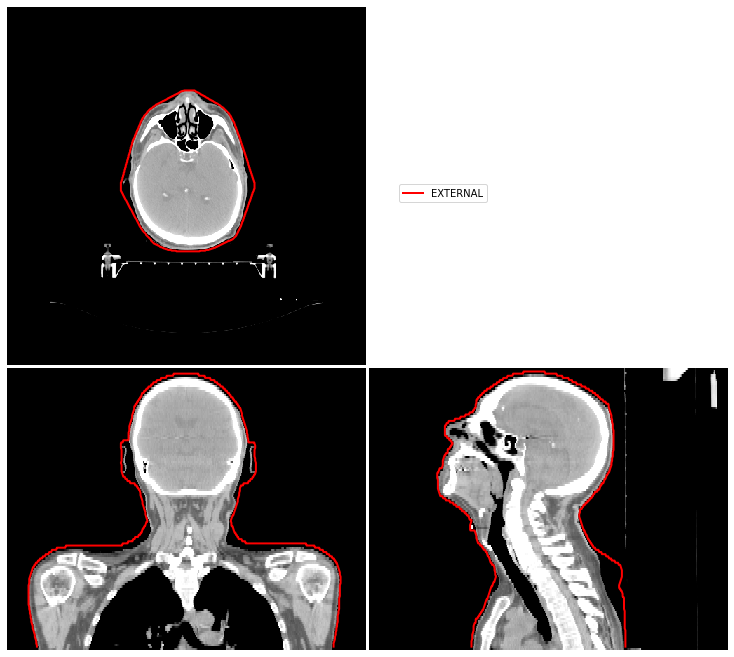

In [9]:
# visualise contours

vis = ImageVisualiser(
    image = img_ct_hn,
    cut = (95,256,256),
    axis = 'ortho',
    window = (-250, 500),
    figure_size_in = 10,
    colormap = plt.cm.Greys_r,
    projection = False,
)
    
# add contours
vis.add_contour(
    contour = {"EXTERNAL":contour_external},
    color= {"EXTERNAL":"red"},
    linewidth=2,
    show_legend=True
)
    
    
fig = vis.show()

<ipython-input-10-fdb788a846eb>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


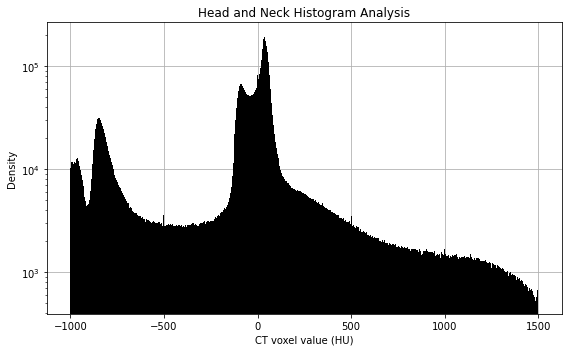

In [10]:
# extract the image values (as a numpy array)
vals_ct_hn = sitk.GetArrayFromImage(img_ct_hn)

# extract the contour (mask)
vals_contour_external = sitk.GetArrayFromImage(contour_external)

# just analyse voxels inside the patient
vals_inside_patient = vals_ct_hn[np.where(vals_contour_external)]

# plot a histogram
fig, ax = plt.subplots(1,1, figsize=(8,5))

ax.hist(
    vals_inside_patient.flatten(),
    bins = np.linspace(-1000,1500,500), # make 500 bins between -1000 and 1500
    color = "black", # change to something else if you like!
)

# plotting options

ax.set_yscale("log") # choose from "log", "linear", etc.
ax.set_xlabel("CT voxel value (HU)")
ax.set_ylabel("Density")
ax.set_title("Head and Neck Histogram Analysis")

# more options
ax.grid(); ax.set_axisbelow(True)

fig.tight_layout()
fig.show()

#### Describe the types of materials that correspond different peaks in this graph.

From the histogram analysis of the head and neck scan we can observe four peaks.
- The first peak (~-1000) corresponds to air.
- The second peak (above -1000) corresponds to lungs.
- The third peak (bellow 0) corresponds to fat structures.
- The fourth peak (above 0) corresponds to soft tissue such as muscle and white/gray matter (brain).

### Question 2
By varying the intensity windowing and slice position, generate a 2D sagittal image from the HN CT scan in which the metal plate in the neck can be clearly observed.

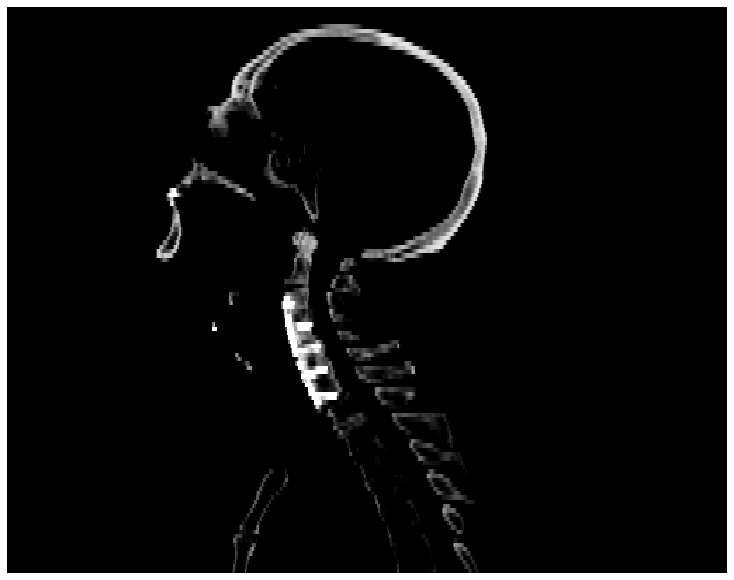

In [11]:
# modify the value of `cut` and `window` as appropriate.
# i.e. replace ? with valid numbers!

vis = ImageVisualiser(
    image = img_ct_hn,
    #cut = (95,256,256),
    axis = 'x',
    window = (300,1500),
    figure_size_in = 10,
    colormap = plt.cm.Greys_r,
    projection = False,
)
    
fig = vis.show()

### Question 3
Using an appropriate threshold, create a segmentation of all the voxels in the HN CT scan that have an attenuation similar to bone. 

Visualise this segmentation, and describe the results.

In [12]:
# thresholding an image to create a mask
# replace ? with correct values to match the CT number of bone
bone_mask_threshold = sitk.BinaryThreshold(img_ct_hn, lowerThreshold=160, upperThreshold=1600) 

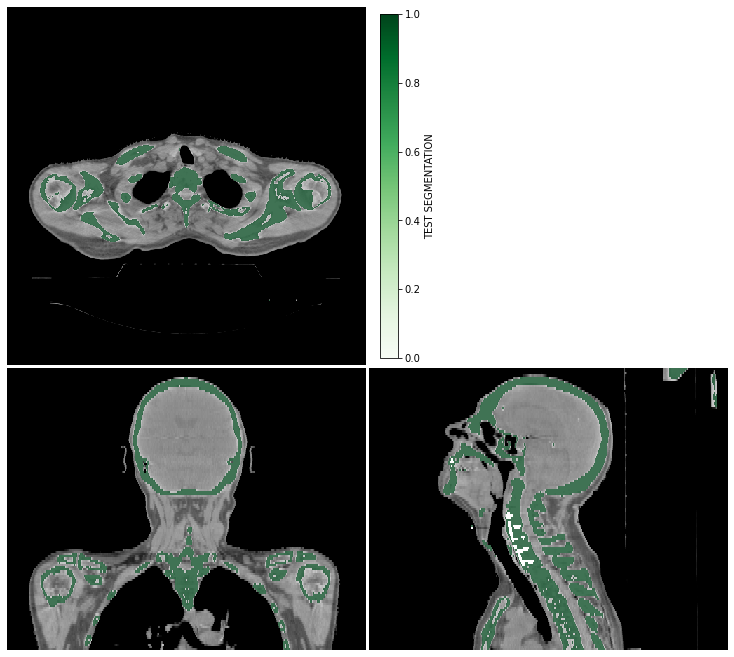

In [13]:
# we can visualise the segmentation as a scalar overlay
# this can be more helpful than contours!

vis = ImageVisualiser(
    image = img_ct_hn,
    cut=(33,256,256),
    figure_size_in=10
)
    
vis.add_scalar_overlay(
    bone_mask_threshold,
    name = "TEST SEGMENTATION",
    alpha = 0.75,
    min_value = 0,
    max_value = 1,
    colormap = plt.cm.Greens
)
    
    
fig = vis.show()

#### Describe the results.

We obtained a segmentation of bone structures using a threshold of [160,1600]. The lower threshold of 160 allowed appropriate segmentation of the ribs, humerus head, scapula, and vertebral column. If a higher threshold (>160) was used an incomplete segmentation of the humerus head, scapula and ribs was obtained. In the other hand, a lower threshold (<160) caused soft tissue structures to appear in the segmentation.

The upper threshold of 1600 guaranteed a correct segmentation of the skull without segmentation of the metal plate in the neck.

### Question 4
Using at least one post-processing algorithm, produce an improved bone segmentation, and describe your choices and reasoning.

Examples of post-processing include connected component analysis and morphological operations (hole filling, closing, etc.). 

Do not perform any manual editing.


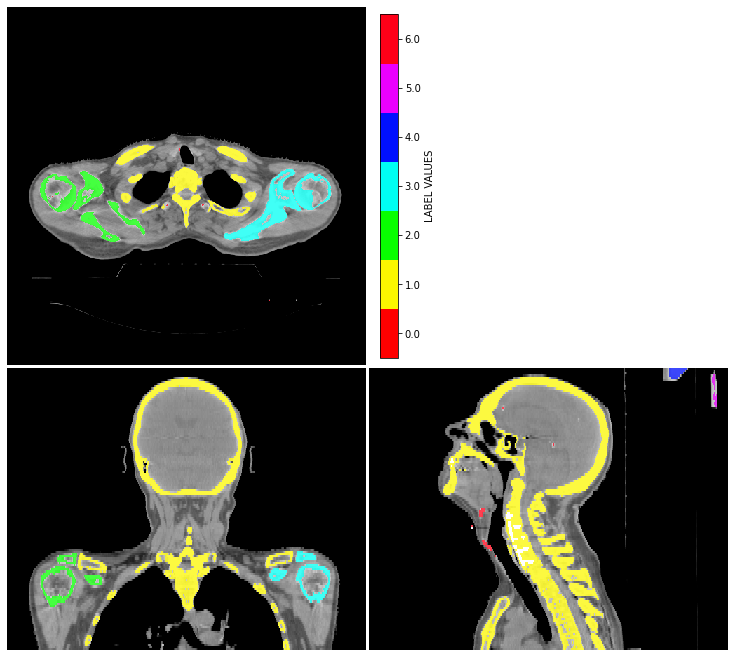

In [14]:
# connected component analysis

# run the simpleitk function
bone_mask_con_com = sitk.RelabelComponent(sitk.ConnectedComponent(bone_mask_threshold))

# YOU NEED TO VISUALISE THE CONNECTED COMPONENTS TO CHOOSE
vis = ImageVisualiser(
    image = img_ct_hn,
    cut=(33,256,256),
    figure_size_in=10
)

vis.add_scalar_overlay(
    bone_mask_con_com,
    name = "LABEL VALUES",
    alpha = 0.75,
    min_value = 0,
    max_value = 6,
    discrete_levels=7,
    mid_ticks=True,
    colormap = plt.cm.hsv
)

fig = vis.show()

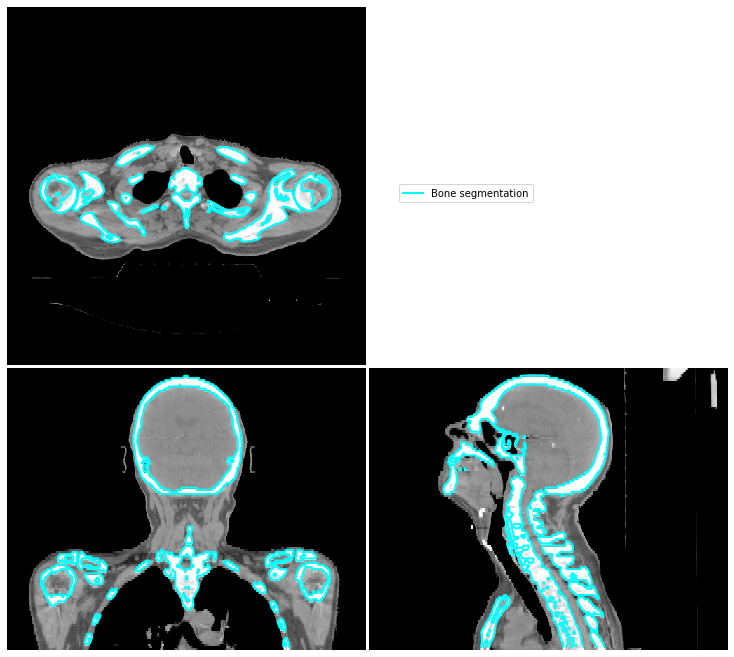

In [15]:
# now manually choose the correct labels
# uncomment if you need more than one label
bone_mask_select = (bone_mask_con_com==1)  + (bone_mask_con_com==2) + (bone_mask_con_com==3)

# display as a contour or scalar overlay
vis = ImageVisualiser(
    image = img_ct_hn,
    cut=(33,256,256),
    figure_size_in=10
)
    
vis.add_contour(
    contour = {"Bone segmentation":bone_mask_select},
    color= {"Bone segmentation":"cyan"}, # see: https://matplotlib.org/stable/gallery/color/named_colors.html for a full list
)
    
fig = vis.show()

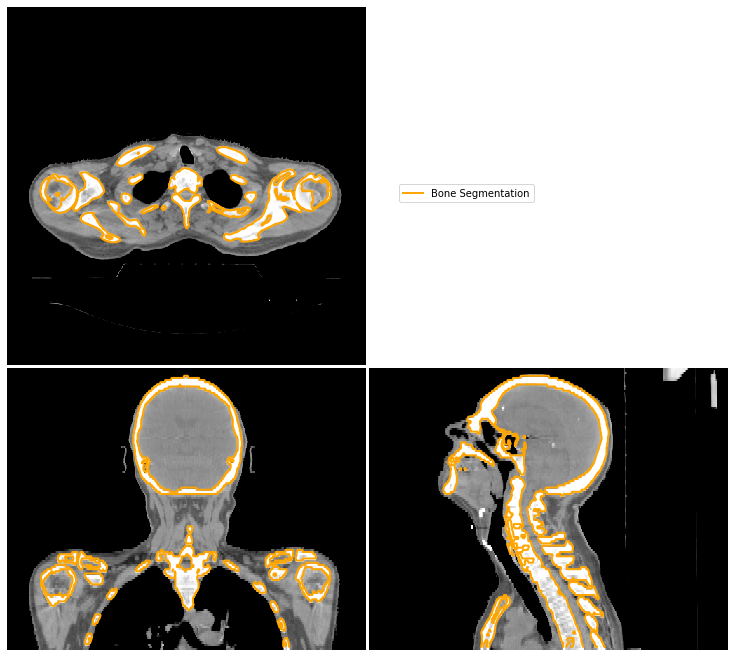

In [16]:
# morphological operations

# run the simpleitk function
#bone_mask_morph = sitk.BinaryMorphologicalClosing(bone_mask_select, (2,4,2)) # the last numbers are the number of voxels to erode in the (sagittal, coronal, axial) directions
bone_mask_morph = sitk.BinaryFillhole(bone_mask_select)
#bone_mask_morph = sitk.BinaryDilate(bone_mask_select)
#bone_mask_morph = sitk.BinaryErode(bone_mask_morph)
# other options
# sitk.BinaryErode : shrinks a segmentation
# sitk.BinaryDilate : the opposite of erode, expands a segmentation
# sitk.BinaryFillhole: fills small holes
# sitk.BinaryMorphologicalClosing: a more complex hole filling algorithm
#                                  specify the max hole size: (sag, cor, ax)

# display as a contour or scalar overlay
vis = ImageVisualiser(
    image = img_ct_hn,
    cut=(33,256,256),
    figure_size_in=10
)
    
vis.add_contour(
    contour = {"Bone Segmentation":bone_mask_morph},
    color= {"Bone Segmentation":"orange"},
)
    
fig = vis.show()

#### Describe your choice of algorithm/s and reasoning.

The BinaryFillhole morphological operation was used since the initial threshold was able to correctly segment most of the bone structures. BinaryFillhole was used since post-processing was needed to fill minor holes on the spinal collumn. BinaryFillhole was able to fill the small holes while preserving the segmentation of the spinous process. Albeit BinaryMorphologicalClosing was able to fill holes more efficiently, it was not used since it merged together the contours of the spinous process.

### Question 5

Apply your bone segmentation method to the body scan. 

Include visualisations (at least one set of orthogonal image slices or MIP slices) to support your answer.

In [17]:
# now repeat for the body scan

img_ct_body = sitk.ReadImage("./data/task_1/BODY_CT.nii.gz")

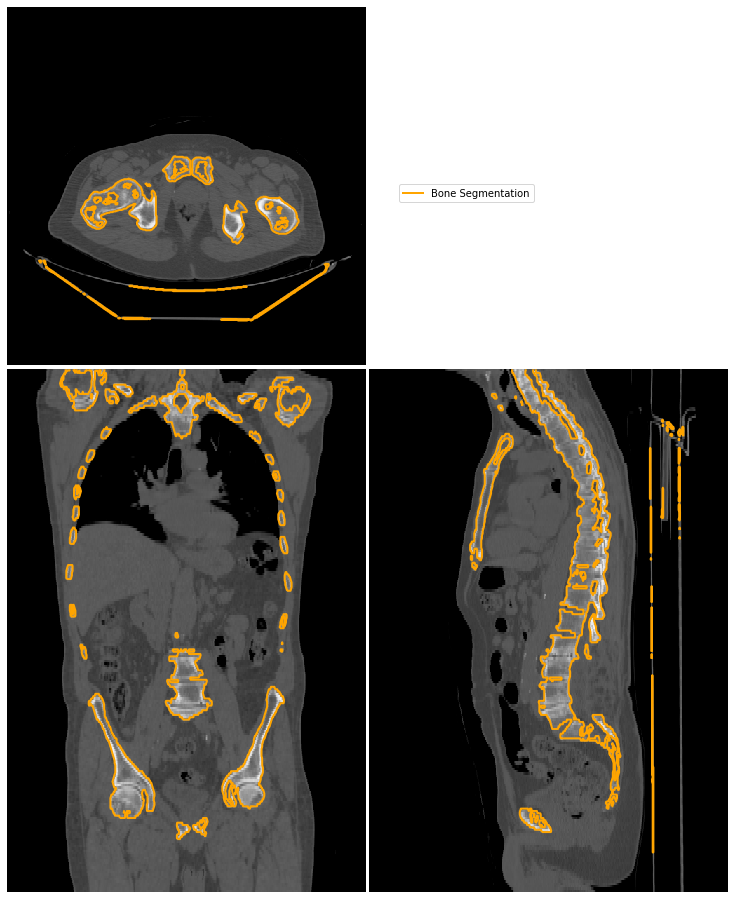

In [24]:
# put your code here
bone_mask_threshold = sitk.BinaryThreshold(img_ct_body, lowerThreshold=160, upperThreshold=1600) 
bone_mask_con_com = sitk.RelabelComponent(sitk.ConnectedComponent(bone_mask_threshold))
# uncomment if you need more than one label
bone_mask_select = (bone_mask_con_com==1)  + (bone_mask_con_com==2) + (bone_mask_con_com==3)
bone_mask_morph = sitk.BinaryFillhole(bone_mask_select)

# display as a contour or scalar overlay
vis = ImageVisualiser(
    image = img_ct_body,
    cut=(33,256,256),
    figure_size_in=10,
    axis='ortho',
    window=(-500,2000)
    #limits=(0, 2000)
)
    
vis.add_contour(
    contour = {"Bone Segmentation":bone_mask_morph},
    color= {"Bone Segmentation":"orange"},
)
    
fig = vis.show()

#### Discuss the performance on this new image.

The segmentation is able to contour the ribs, femur head, and humerus head. It is also able to contour the vertebral column preserving the spinous process and space between vertebrae. Nevertheless, the segmentation is not able to adequately contour the sacrum and coccyx. Furthermore, the segmentation is also contouring some sections of the couch.

#### Are any changes required to work on this new image? 
In order to achive a better segmentation the couch must be eliminated from the segmentation. This could be done by changing the threshold. Additionaly, a better countour of the coccyx and sacrum is required. The use of BinaryMorphologicalClosing could improve the contouring of this seccion.

***
# Task 2
## CT-CT image registration and 18FDG-PET analysis.

A patient has received $^{18}$FDG-PET scan as part of their treatment for head and neck cancer, to better visualise metabolically active tumour regions. 

This PET scan also includes a CT that is used for attenuation correction, and both images together are referred to as the PET-CT. 

With advice from their medical team, this patient has decided to receive radiotherapy.

Prior to radiotherapy the patient has recieved a simulation CT scan (i.e. set up in the same position as for treatment).

A radiation oncologist has delineated the primary tumour (gross tumour volume, GTV). 

When the PET-CT scan was acquired, the patient position was slightly different to the simulation CT. 

As a medical physicist, you have been asked to help with the co-registration of the PET-CT to the simulation CT.

In [25]:
# we need to import more functionality

from platipy.imaging.registration.linear import linear_registration
from platipy.imaging.registration.deformable import fast_symmetric_forces_demons_registration
from platipy.imaging.registration.utils import apply_transform

from platipy.imaging.label.utils import get_com # get the centre of mass

In [26]:
# read in the data for this task

# the simulation ct and contour
img_ct_sim = sitk.ReadImage("./data/task_2/HN_CT_SIMULATION.nii.gz")
contour_gtv = sitk.ReadImage("./data/task_2/HN_RTSTRUCT_TUMOUR.nii.gz")

img_ct_ac = sitk.ReadImage("./data/task_2/HN_CT_AC.nii.gz")
img_pet = sitk.ReadImage("./data/task_2/HN_PET.nii.gz")

# VERY IMPORTANT
# THE PET IMAGE HAS A DIFFERENT RESOLUTION
# SO WE MUST RESAMPLE IT INTO THE SAME SPACE AS THE CT
img_pet = sitk.Resample(img_pet, img_ct_ac)

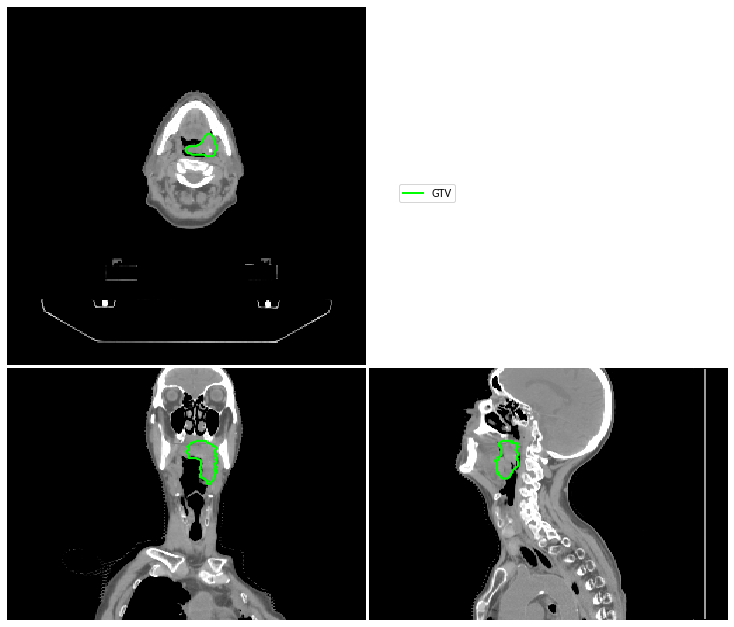

In [27]:
# visualise the planning CT

vis = ImageVisualiser(
    image = img_ct_sim,
    cut = get_com(contour_gtv), # a useful way to specify the slice location
    figure_size_in = 10
)

vis.add_contour(
    contour = {"GTV":contour_gtv},
    color= {"GTV":"lime"},
    show_legend=True
)

fig = vis.show()

### Question 1
By manually adjusting the slice location of the PET scan, visualise a 2D image slice from the PET-CT at the GTV location. 

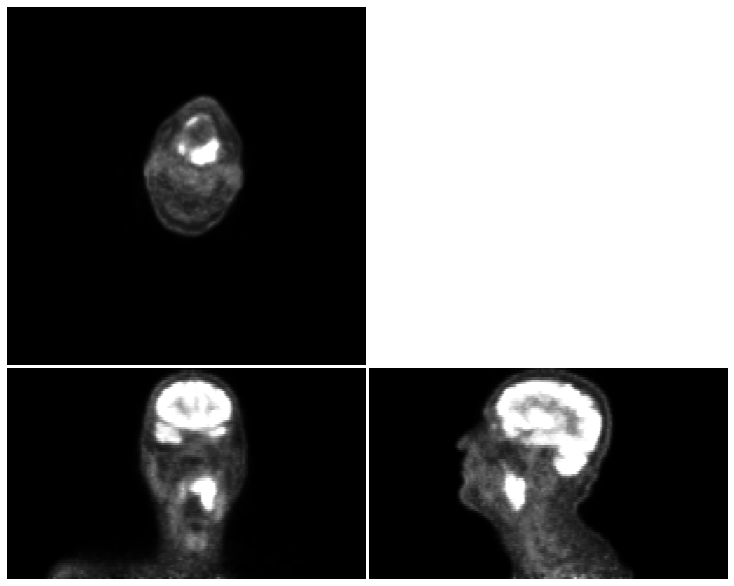

In [28]:
# put your code here
vis = ImageVisualiser(
    image = img_pet,
    cut=(38,210,290),
    figure_size_in=10
)
fig = vis.show()

#### Describe the appearance of the GTV on the PET scan, and discuss potential the cause of this appearance.

The GTV appears in the PET scan as a bright area in the neck region. This area appears bright since is where most of the $^{18}$FDG has concentrated.

### Question 2

Use a linear registration method to align the attenuation correction CT to the simulation CT.

The valid options for `reg_method`:
- `"translation"`
- `"rigid"`
- `"similarity"`
- `"affine"`
- `"scaleversor"` (rigid + anisotropic scale)
- `"scaleskewversor"` (affine + anisotropic scale)


The valid options for `metric`:
- `"mean_squares"`
- `"correlation"`
- `"mattes_mi"` (MI = mutual information)
- `"joint_hist_mi"` (MI = mutual information)

The valid options for `optimiser`:
- `"gradient_descent"` (usually the best option)
- `"gradient_descent_line_search"`
- `"lbfgsb (limited-memory Broyden–Fletcher–Goldfarb–Shanno (bounded).)"`

Note: you shouldn't have to change the optimisation option, but if a registration is failing you can try out the other choices.


In [29]:
# to get more info:
#linear_registration?

In [30]:
ac = sitk.GetArrayFromImage(img_ct_sim)
sim = sitk.GetArrayFromImage(img_ct_ac)
print("Moving Image:\nMean: ", ac.mean(), " Range: [", ac.min(), ",", ac.max(),"]")
print("\nFixed Image:\nMean: ", sim.mean(), " Range: [", sim.min(), ",", sim.max(),"]")

Moving Image:
Mean:  -831.8491192027035  Range: [ -1024 , 2976 ]

Fixed Image:
Mean:  -1324.1028420342338  Range: [ -3024 , 3071 ]


In [31]:
# linear registration

img_ct_ac_linear, tfm_ct_ac_linear = linear_registration(
    fixed_image = img_ct_sim,
    moving_image = img_ct_ac,
    reg_method = "rigid", # replace this with a valid option
    metric = "correlation", # replace this with a valid option
    optimiser = "gradient_descent", # replace this with a valid option
    shrink_factors = [8, 8, 4], # try out different options
    smooth_sigmas = [4, 2, 0], # try out different options
    sampling_rate = 0.5, # between 0 and 1. increase = better accuracy, but slower
    default_value = -1000, # the "background", for CT this is -1000
    verbose = False, # change to True to print the progress
)

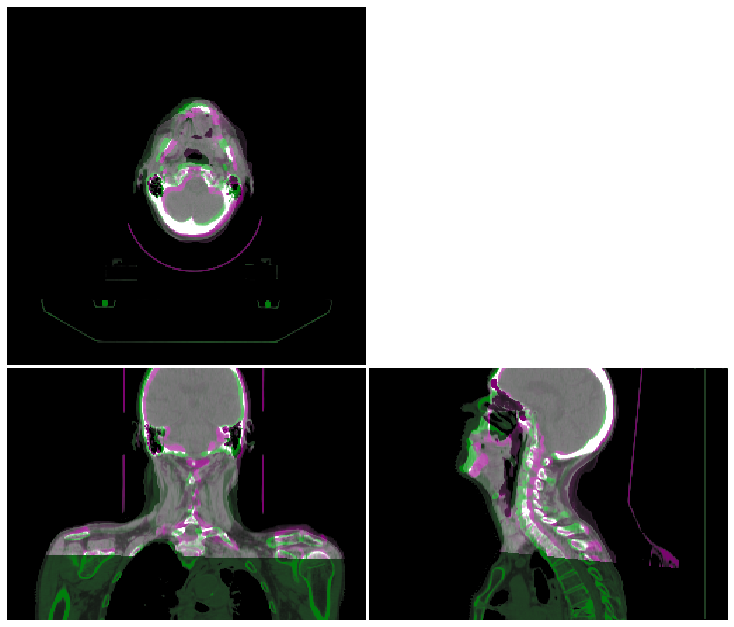

In [32]:
# visualise the planning CT
vis = ImageVisualiser(
    image = img_ct_sim,
    cut = (160,130,128),
    figure_size_in = 10
)

# add the AC CT as a comparison
vis.add_comparison_overlay(img_ct_ac_linear)

fig = vis.show()

#### Discuss why you chose the registration parameters you used, in particular the type of transform and similarity metric. 

Since we can asume that both scans where made with the patient in similar position and the patient movement is minimum (lungs outside of the FOV) we can use rigid registration. 

Given a different intensity range between the fixed and moving images the mean square metric was not used. Instead a correlation metric was used to perfom the registration since a correlation between both intensities can be made. For this registration mutual information metrics where not used since they provided with inconsistent results.



#### Describe the co-registration accuracy, using visualisations as appropriate.

From a visual inspection of the registration, we can observe that the method was able to align the skull and body of the vertebrae with appropriate accuracy. Nevertheless, structures such as the maxilla, mandible, spinous and transverse processes, and scapula where not registered adequately.

### Question 3
Use a deformable registration method to refine these results.

In [33]:
# read the doc string for more info!
#fast_symmetric_forces_demons_registration?

In [34]:
# deformable registration

img_ct_ac_dir, tfm_ct_ac_dir, dvf_ct_ac = fast_symmetric_forces_demons_registration(
    fixed_image = img_ct_sim,
    moving_image = img_ct_ac_linear,
    resolution_staging=[8, 4, 2], # this is the resolution in mm
    iteration_staging=[10, 10, 10], # more iterations = better accuracy but slower
    isotropic_resample=True, # usually best to set this to True
    default_value=-1000,
    verbose=False,
)

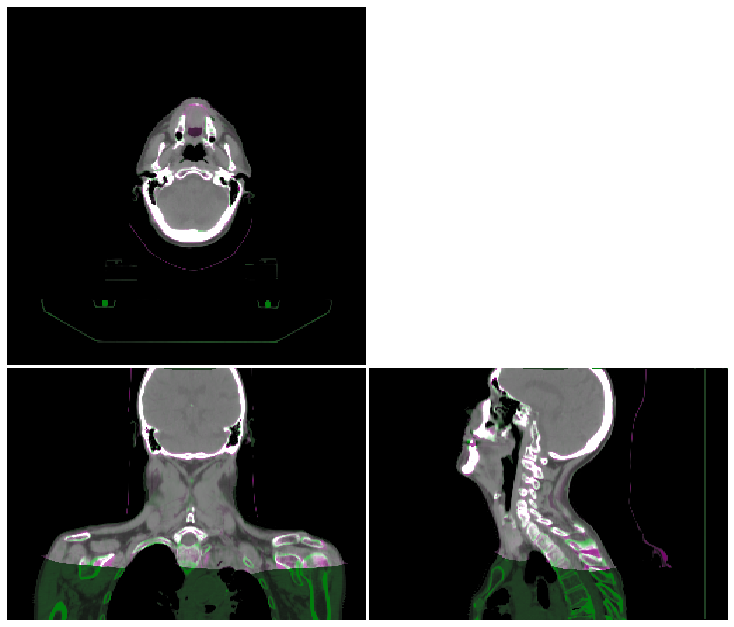

In [35]:
# visualise the DIR results
vis = ImageVisualiser(
    image = img_ct_sim,
    cut = (170,133,126),
    figure_size_in = 10
)

vis.add_comparison_overlay(img_ct_ac_dir)

fig = vis.show()

#### Describe the co-registration accuracy following this second registration stage, using visualisations as appropriate.

The deformable registration produces a better result with a higher accuracy when compared to the linear registration obtained previously (question 2). The registration was able to align the skull (including mandible and maxilla), scapula, head of humerus, and vertebral column. On the other hand, the registration presents small misalignments in the spinous and transverse processes.

### Question 4
Propagate the transform to the PET image, and visualise the simulation CT with the PET overlaid and the GTV shown as a contour.
[check TG-132 language]

In [36]:
# we will use the `apply_transform` function, get some information about it:
#apply_transform?

In [37]:
# combine the chain of transforms
tfm_ct_ac_total = sitk.CompositeTransform((tfm_ct_ac_linear, tfm_ct_ac_dir))

# apply to the pet image
img_pet_dir = apply_transform(img_pet, reference_image=img_ct_sim, transform=tfm_ct_ac_total)

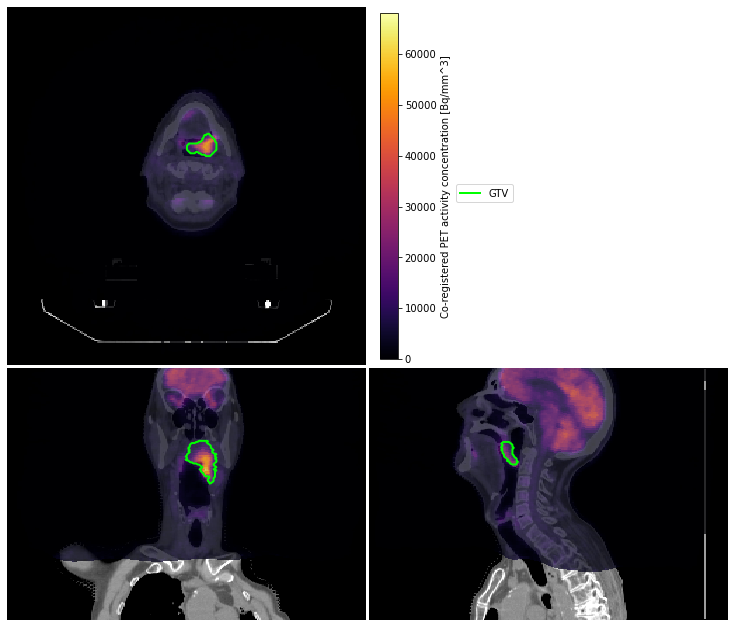

In [61]:
# visualise!
vis = ImageVisualiser(
    image = img_ct_sim,
    cut =  (150,100,133),#get_com(contour_gtv),
    figure_size_in = 10
)

vis.add_scalar_overlay(
    scalar_image = img_pet_dir,
    name = "Co-registered PET activity concentration [Bq/mm^3]",
    colormap = plt.cm.inferno,
)

vis.add_contour(
    contour = {"GTV":contour_gtv},
    color= {"GTV":"lime"},
    show_legend=True
)

fig = vis.show()

#### Describe the alignment between the tumour region as visible on the PET scan with the delineated GTV.

The delineated GTV shows a good alignment with the PET scan. Nevertheless, the delineated GTV shows an overestimation of the tumour region compared to the PET scan in some areas. Furthermore, in some regions the GTV does not contour the whole tumour region. This can be seen on slices axial=150, coronal=100 and sagittal=133.

### Question 5

Compute the total activity (in Bq) of the tumour volume. Compare this to the total activity as provided by the ARPANSA Diagnostic Reference Level (DRL) for a brain PET-CT, found [here](https://www.arpansa.gov.au/research-and-expertise/surveys/national-diagnostic-reference-level-service/current-australian-drls/nm).

For this question, consider how the CT image values were extracted in Task 1, Question 1 to compute the histogram. Some steps:
 - Using a similar approach we can extract the activity concentration at each voxel
 - How could we compute the *activity* at each voxel?
 - Hint: compute the volume of the voxel: `voxel_vol = np.product(img_pet_dir.GetSpacing())`. 

In [46]:
# put your code here

# extract the image values (as a numpy array)
vals_pet = sitk.GetArrayFromImage(img_pet_dir)
# extract the contour (mask)
vals_GTV = sitk.GetArrayFromImage(contour_gtv)

voxel_vol = np.product(img_pet_dir.GetSpacing()) #in mm^3

# just analyse voxels inside the patient
vals_inside_GTV = vals_pet[np.where(vals_GTV)]*voxel_vol#/1000 #1000 mm^3 = ml

vals_inside_GTV = vals_inside_GTV * 10**-6 #in MBq
print("PET: BRAIN")
print("Pharmaceutical: 18-FDG")
#print("Median (MBq): ", np.median(vals_inside_GTV))
print("Total Activity (MBq): ", np.sum(vals_inside_GTV))

PET: BRAIN
Pharmaceutical: 18-FDG
Total Activity (MBq):  655.0958806353481


#### Written response:

The total activity obtained within the contoured GTV was of 655.095 MBq. The obtained activity its greater the DRL provided by ARPANSA (DRL = 250 MBq).

***
# Task 3
## DIR-based functional lung assessment

Deformable image registration can be used to assess lung function, as an alternative to SPECT- or PET-based ventilation and perfusion imaging (e.g. using $^{99\text{m}}$Tc or $^{68}$Ga).

The basis of these DIR methods is measuring changes in images of the lungs in 4D CT scans.

A radiotherapy patient has received a 4D CT scan, gated into 10 phases of the respiratory cycle. 

From this scan, two CT scans corresponding to the peak inhale (breath in) and peak exhale (breath out) are generated.

As a medical physicist registrar, you have been asked to help provide quantitative information. 

This will help the team in implementing a new technique to minimise the radiation dose to well-functioning lung regions.


In [62]:
# read in the data for this task

img_4dct_inhale = sitk.ReadImage("./data/task_3/4DLUNG_CT_INHALE.nii.gz")
img_4dct_exhale = sitk.ReadImage("./data/task_3/4DLUNG_CT_EXHALE.nii.gz")

contours = {"EXHALE":{}, "INHALE":{}}
contours["EXHALE"]["LEFT_LUNG"] = sitk.ReadImage("./data/task_3/4DLUNG_RTSTRUCT_LEFT_LUNG_EXHALE.nii.gz")
contours["EXHALE"]["RIGHT_LUNG"] = sitk.ReadImage("./data/task_3/4DLUNG_RTSTRUCT_RIGHT_LUNG_EXHALE.nii.gz")
contours["INHALE"]["LEFT_LUNG"] = sitk.ReadImage("./data/task_3/4DLUNG_RTSTRUCT_LEFT_LUNG_INHALE.nii.gz")
contours["INHALE"]["RIGHT_LUNG"] = sitk.ReadImage("./data/task_3/4DLUNG_RTSTRUCT_RIGHT_LUNG_INHALE.nii.gz")

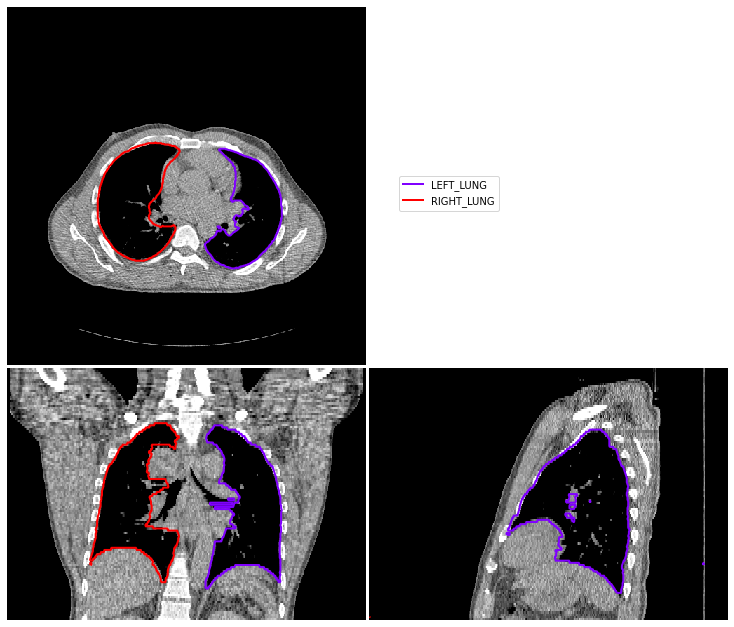

In [63]:
# visualise

vis = ImageVisualiser(img_4dct_exhale, cut=get_com(contours["EXHALE"]["LEFT_LUNG"]), figure_size_in=10)
vis.add_contour(contours["EXHALE"])
fig = vis.show()

### Question 1
Use deformable image registration to warp the peak exhale CT image to the peak inhale CT image.

In [64]:
# register using the fast symmetric forces demons algorithm!

img_4dct_dir, tfm_4dct_dir, dvf_4dct = fast_symmetric_forces_demons_registration(
    fixed_image = img_4dct_inhale,
    moving_image = img_4dct_exhale,
    resolution_staging=[8, 4, 2],
    iteration_staging=[10, 10, 10],
    isotropic_resample=True,
    default_value=-1000,
    verbose=False,
)

Compare this warped exhale image to the peak inhale image

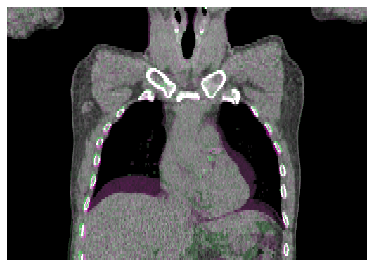

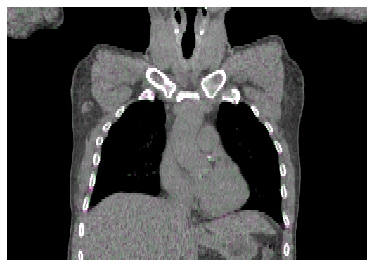

In [65]:
# compare the registration
# BEFORE REG
vis = ImageVisualiser(img_4dct_inhale, axis="y", figure_size_in=5)
vis.add_comparison_overlay(img_4dct_exhale)
fig = vis.show()

# AFTER REF
vis = ImageVisualiser(img_4dct_inhale, axis="y", figure_size_in=5)
vis.add_comparison_overlay(img_4dct_dir)
fig = vis.show()

#### Describe the accuracy of the registration process, using visualisations as required.

The registration was able to efficiently warp the exhale image to the inhale peak. Structures such as the left atrium, left ventricle, costophrenic angles, and diaphragm show a good correspondence.

### Question 2
Compute the magnitude of the deformation field, mask it to the lung volume.

In [66]:
# calculate the magnitude
img_vec_mag = sitk.VectorMagnitude(dvf_4dct)

# mask the the combined lung volume
img_vec_mag_masked = sitk.Mask(img_vec_mag, contours["INHALE"]["RIGHT_LUNG"] | contours["INHALE"]["LEFT_LUNG"])

Visualise this as a scalar overlay on the inhale CT scan using a perceptually uniform colormap.

To find an appropriate colormap see: https://matplotlib.org/stable/tutorials/colors/colormaps.html

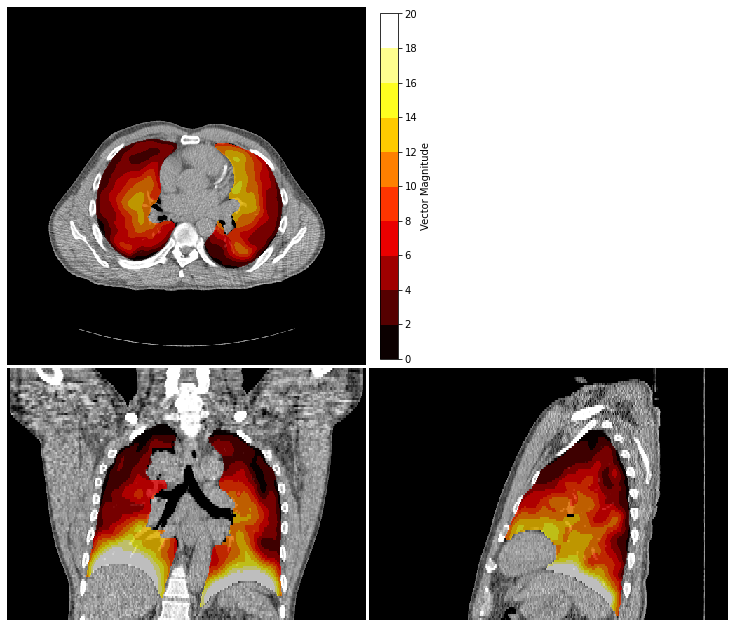

In [67]:
# visualise
# replace ? with a valid PERCENTUALLY UNIFORM colormap

vis = ImageVisualiser(
    img_4dct_inhale, 
    cut=get_com(contours["INHALE"]["LEFT_LUNG"]), 
    figure_size_in=10
)

vis.add_scalar_overlay(
    img_vec_mag_masked,
    colormap = plt.cm.hot,
    discrete_levels = 10,
    max_value = 20,
    name = "Vector Magnitude"
)

fig = vis.show()

#### Where are the largest deformations? Is this what you expected?

As expected, the largest deformation occurs around the costophrenic angles, and diaphragm; since these are the regions involved in the inhale-exhale process. Furthermore, the heart also presents a high deformation since it is susceptible to movement during respiration and its own contraction-relaxation cycle.

### Question 3
Compute the Jacobian determinant of the deformation field, mask it to the lung volume.

In [68]:
# calculate the jacobian determinant
img_jac_det = sitk.DisplacementFieldJacobianDeterminant(sitk.InvertDisplacementField(dvf_4dct))

In [69]:
img_jac_det_mask = sitk.Mask(
    img_jac_det, 
    contours["INHALE"]["RIGHT_LUNG"] | contours["INHALE"]["LEFT_LUNG"]
)

Visualise this as a scalar overlay on the inhale CT scan (with lung contours) using a diverging colormap normalised with 1 at the center.

In [70]:
# create a normalised colormap
from matplotlib import colors
cmap_norm = colors.TwoSlopeNorm(vcenter=1)

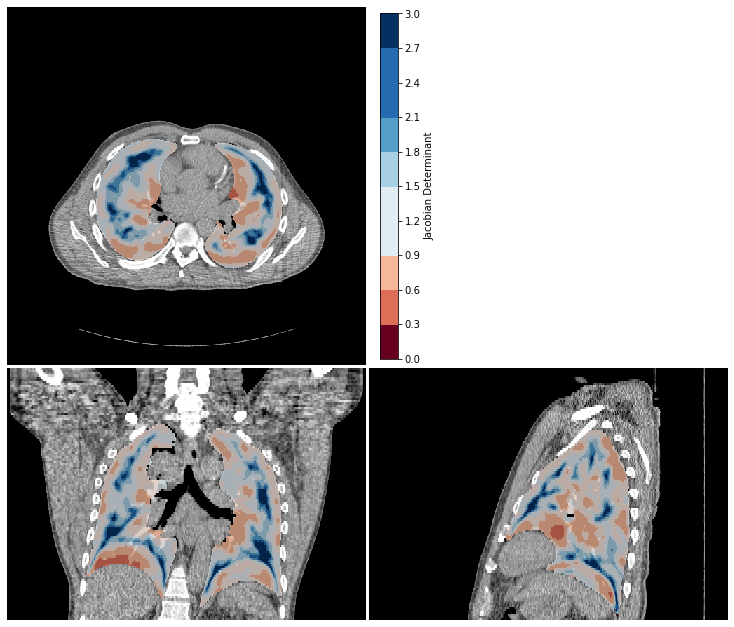

In [71]:
# visualise as a scalar overlay
# replace ? with a valid DIVERGING colormap
vis = ImageVisualiser(
    img_4dct_inhale, 
    cut=get_com(contours["INHALE"]["LEFT_LUNG"]), 
    figure_size_in=10
)

vis.add_scalar_overlay(
    scalar_image = img_jac_det_mask,
    colormap = plt.cm.RdBu,
    discrete_levels = 10,
    min_value = 0,
    max_value = 3,
    name = "Jacobian Determinant", norm = cmap_norm
)

fig = vis.show()

### Question 4

#### With reference to the above results, briefly describe how the lungs change during respiration. 

From the Jacobian determinant we can observe that the regions closer to the costodiaphragmatic recesses and central regions of the lung present volumetric expansion (>1). Areas closer to the walls of the lungs present volumetric compression (<1).

#### Based on the analysis of the deformable image registration, are there any regions associated with non-physical deformation? 
Hint: which of the above metrics (vector magnitude, Jacobian determinant) can we used to identify non-physical deformations?

#### What proportion of the total lung volume is affected by this non-physical deformation?
Hint: can you extract all of the appropriate metric values in the lung regions?

In [72]:
# put your code here
img_jac_det_mask_arr= sitk.GetArrayFromImage(img_jac_det_mask) #array of Jacobian determinant inside the lungs
nonPhys = len(img_jac_det_mask_arr[img_jac_det_mask_arr<0]) #we obtain the negative values 
LungPix = np.product(img_jac_det_mask_arr.shape) #total number of pizels in lung
nonPhysTotalVol = nonPhys  / LungPix * 100 #obtain the percentage of lung affected by non-physical deformation
print("Percentage of lung that presents non-physical deformation: "+ str(nonPhysTotalVol) +"%")

Percentage of lung that presents non-physical deformation: 0.0005151471521100427%


### Answer

The Jacobian determinant determines the volumetric changes in the image. Values grater than one represents a volume expansion, values smaller than one represent a volume compression, and negative values represent a change in direction or fold. This last scenario (values<0) represent non-physical deformations.

***
# Task 4
## MRI-CT fusion for brain imaging

It can be beneficial to delineate radiotherapy planning volumes using CT imaging together with another modality, such as MRI, for improved soft-tissue contrast and functional imaging.

A radiation oncologist is treating a patient for brain cancer. 

In addition to the simulation CT acquired to facilitate treatment planning, there were two MRI sequences acquired: T2w FSE (fast spin echo) and T2w FLAIR (fluid-attenuated attenuated inversion recovery). 

As a medical physicist, you have been asked to provide assistance in the fusion (co-registration) of the brain MRI and CT scan. 

This will improve the visualisation of the brain tumour, which could lead to more confidence in the delineation of radiotherapy planning volumes.

In [73]:
# read in the data for this question

img_brain_ct = sitk.ReadImage("./data/task_4/BRAIN_CT.nii.gz")
img_brain_mri_fse = sitk.ReadImage("./data/task_4/BRAIN_MR_AX_T2_FSE.nii.gz")
img_brain_mri_flair = sitk.ReadImage("./data/task_4/BRAIN_MR_AX_T2_FLAIR.nii.gz")

### Question 1
Which image (CT, T2w FSE, or T2w FLAIR) should be chosen as the reference image (i.e. the target image), and which should be selected as the moving image (i.e. the image that is transformed), and why? 

For choosing which MRI sequence might be preferred, you should investigate acquisition/image parameters.

In [74]:
# to get information about an image, use
print("CT")
print("Image resoltuion:", img_brain_ct.GetSpacing())
print("Image size:      ", img_brain_ct.GetSize())
print("Image pixel type:", img_brain_ct.GetPixelIDTypeAsString())

CT
Image resoltuion: (0.48828125, 0.48828125, 5.201475143432617)
Image size:       (512, 512, 30)
Image pixel type: 16-bit signed integer


In [75]:
print("T2w FSE")
print("Image resoltuion:", img_brain_mri_fse.GetSpacing())
print("Image size:      ", img_brain_mri_fse.GetSize())
print("Image pixel type:", img_brain_mri_fse.GetPixelIDTypeAsString())

T2w FSE
Image resoltuion: (0.42969998717308044, 0.42969998717308044, 4.999999523162842)
Image size:       (512, 512, 28)
Image pixel type: 16-bit signed integer


In [76]:
print("T2w FLAIR")
print("Image resoltuion:", img_brain_mri_flair.GetSpacing())
print("Image size:      ", img_brain_mri_flair.GetSize())
print("Image pixel type:", img_brain_mri_flair.GetPixelIDTypeAsString())

T2w FLAIR
Image resoltuion: (0.8593999743461609, 0.8593999743461609, 4.999999523162842)
Image size:       (256, 256, 28)
Image pixel type: 16-bit signed integer


#### Answer

Given that the treatment plan will be created using the CT scan, this would be used as the reference image. Since the T2w FSE has a resolution comparable to that of the CT scan and similar image size this image can be used as the moving image for the co-registration.

### Question 2
Use an appropriate co-registration algorithm to align the two modalities. For this, you may use either MRI sequence. 

In [77]:
# perform linear registration
# replace ? with valid options!
img_brain_registered, tfm_brain = linear_registration(
    fixed_image = img_brain_ct,
    moving_image = img_brain_mri_fse,
    reg_method='rigid',
    metric="correlation",
    optimiser="gradient_descent",
    shrink_factors=[8,4,2],
    smooth_sigmas=[4,2,0],
    sampling_rate=0.9,
    default_value=-1000,
    verbose=False,
)

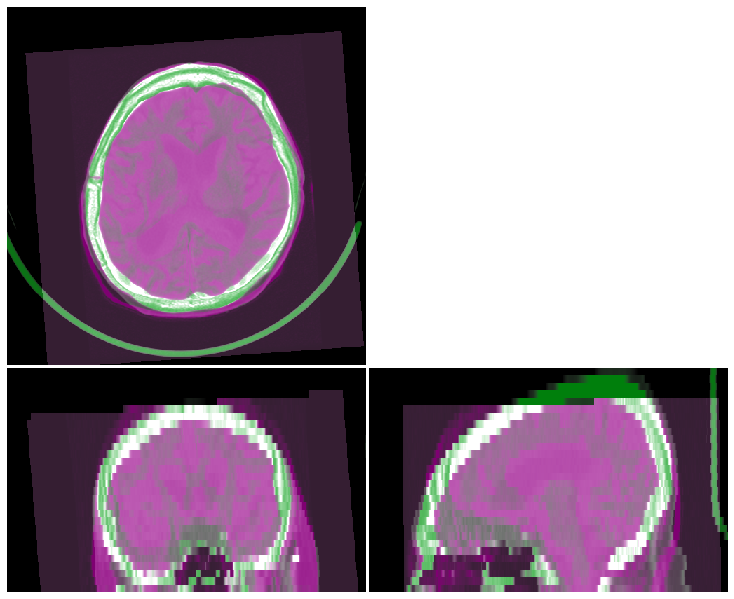

In [78]:
# visualise as a comparison overlay
# replace ? with your chosen reference (fixed) image
vis = ImageVisualiser(img_brain_ct, 
                      cut=(14,200,290),
                      figure_size_in=10)
vis.add_comparison_overlay(img_brain_registered)
fig = vis.show()

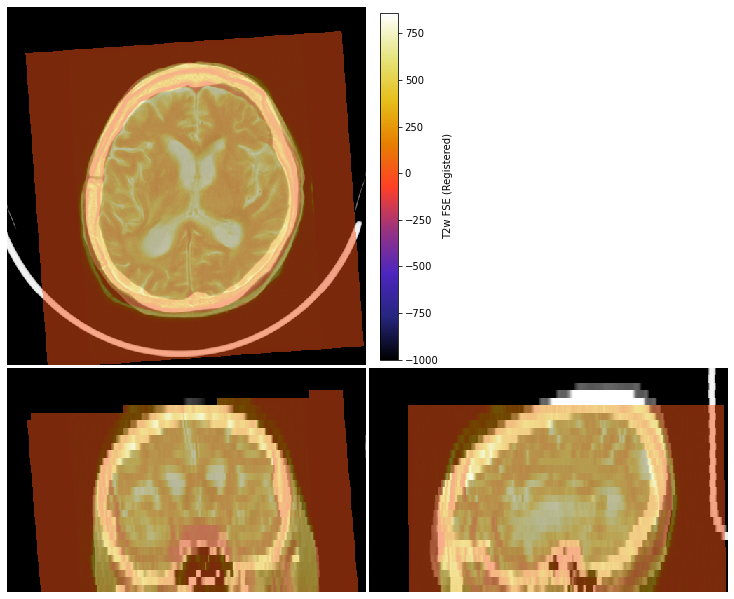

In [79]:
# visualise as a scalar overlay
vis = ImageVisualiser(img_brain_ct, 
                      cut=(14,200,190),
                      figure_size_in=10)

vis.add_scalar_overlay(
    img_brain_registered,
    colormap=plt.cm.CMRmap,
    name = "T2w FSE (Registered)",
    alpha=0.5
)

fig = vis.show()

#### Discuss the registration parameters you chose, in particular, the type of transform and metric.

The metric used was chosen following the same criteria as in Task 2 Question 2. A rigid method was preferred since the intensity range between both images are different and we can assume that the patient movement should be minimum. Also, a correlation metric was used given that the intensity range was different between images.

#### By using appropriate visualisations, describe the accuracy of the co-registration.

From a visual inspection we can observe that a poor registration was achieved. Comparing the axial, coronal and sagittal we can observe that the axial is the only plane that presents a significant improvement in the registration. Compared to the other planes, in the axial plane registration of the skull and ventricles was achieved. Nevertheless, the results are not adequate and a non-linear registration should be performed in order to achieve an adequate result.

***
# Task 5
## Atlas-based automatic segmentation of radiotherapy volumes 

Atlas-based techniques are frequently used in radiotherapy to assist treatment planning.

A cancer therapy centre is currently investigating the how automatic segmentation could be used for patient being treated for head and neck cancers.

These patients routinely receive T2w MRI scans. 

Currently, these is a focus on the parotid glands, which are the largest salivary glands and are important during radiotherapy planning as doses exceeding established constraints can increase the risks of severe toxicities.

As a medical physicist, you have been asked to provide assistance in validating an atlas-based automatic segmentation tool. 

You have collected data (imaging and contours) for three patients, and will conduct an investigation.

### Question 1
Visualise all three patient images with the contours clearly visible.

In [80]:
# read in data for one patient
#Patient 1
img_001 = sitk.ReadImage("./data/task_5/RTMAC_LIVE_001/IMAGES/RTMAC_LIVE_001_MRI_T2W.nii.gz")

contours_001 = {
    "PAROTID_L":sitk.ReadImage("./data/task_5/RTMAC_LIVE_001/STRUCTURES/RTMAC_LIVE_001_RTSTRUCT_PAROTID_L.nii.gz"),
    "PAROTID_R":sitk.ReadImage("./data/task_5/RTMAC_LIVE_001/STRUCTURES/RTMAC_LIVE_001_RTSTRUCT_PAROTID_R.nii.gz"),
}
# Patient 2
img_002 = sitk.ReadImage("./data/task_5/RTMAC_LIVE_002/IMAGES/RTMAC_LIVE_002_MRI_T2W.nii.gz")

contours_002 = {
    "PAROTID_L":sitk.ReadImage("./data/task_5/RTMAC_LIVE_002/STRUCTURES/RTMAC_LIVE_002_RTSTRUCT_PAROTID_L.nii.gz"),
    "PAROTID_R":sitk.ReadImage("./data/task_5/RTMAC_LIVE_002/STRUCTURES/RTMAC_LIVE_002_RTSTRUCT_PAROTID_R.nii.gz"),
}

# Patient 3
img_003 = sitk.ReadImage("./data/task_5/RTMAC_LIVE_003/IMAGES/RTMAC_LIVE_003_MRI_T2W.nii.gz")

contours_003 = {
    "PAROTID_L":sitk.ReadImage("./data/task_5/RTMAC_LIVE_003/STRUCTURES/RTMAC_LIVE_003_RTSTRUCT_PAROTID_L.nii.gz"),
    "PAROTID_R":sitk.ReadImage("./data/task_5/RTMAC_LIVE_003/STRUCTURES/RTMAC_LIVE_003_RTSTRUCT_PAROTID_R.nii.gz"),
}

In [81]:
img_003.GetSpacing()

(0.5, 0.5, 2.0)

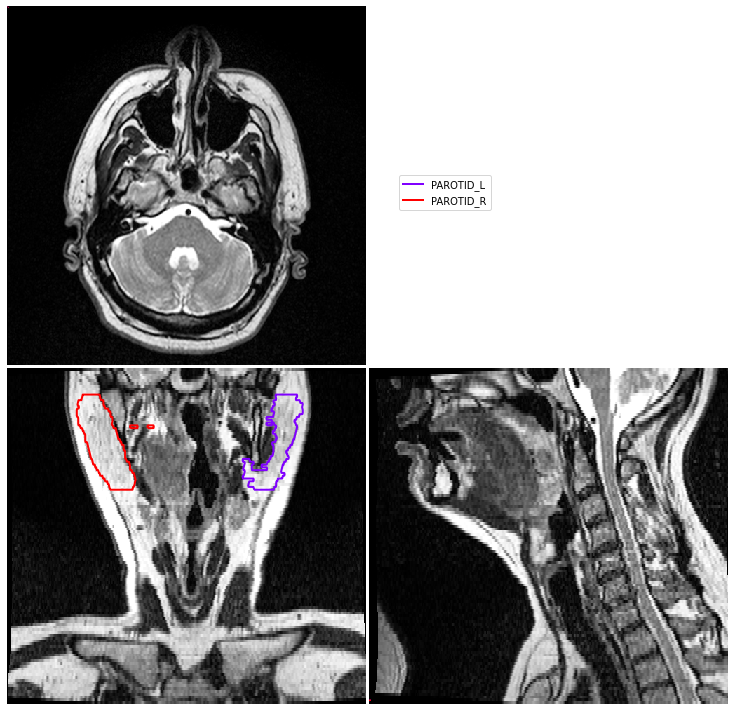

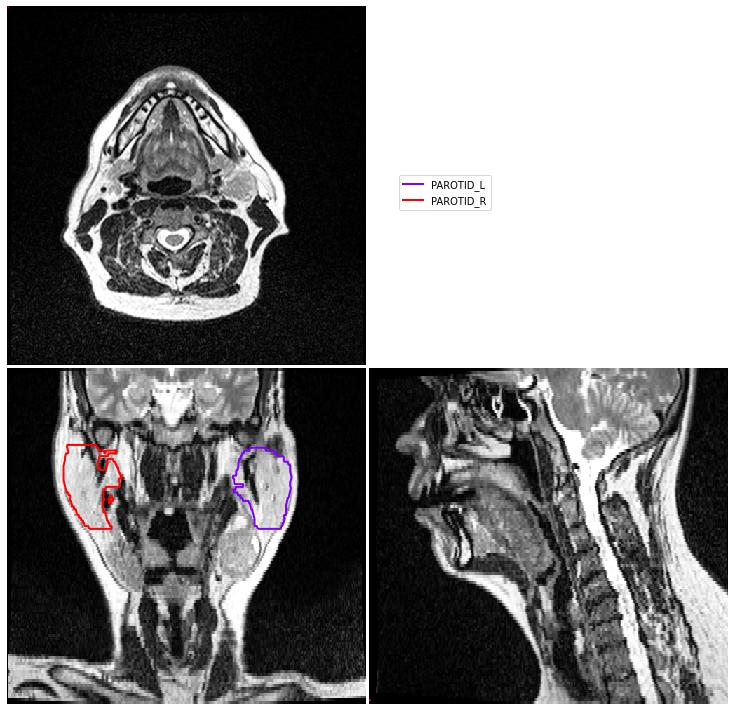

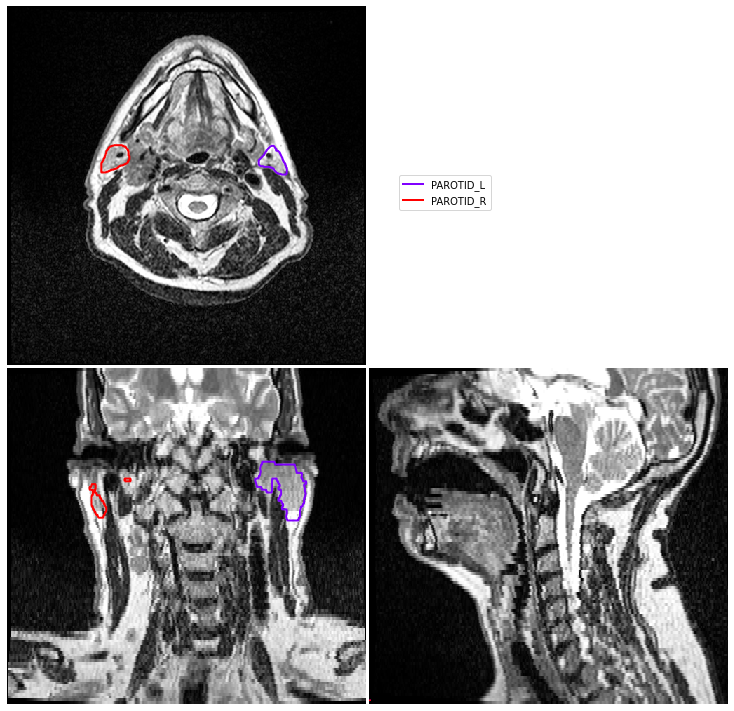

In [82]:
# visualise
vis = ImageVisualiser(img_001, 
                      cut=(116,256,256),#cut=get_com(contours_001["PAROTID_L"]), 
                      figure_size_in=10)
vis.add_contour(contours_001)
fig = vis.show()

vis2 = ImageVisualiser(img_002, 
                       cut=(60,256,256),#cut=get_com(contours_002["PAROTID_L"]), 
                       figure_size_in=10)
vis2.add_contour(contours_002)
fig = vis2.show()

vis3 = ImageVisualiser(img_003, 
                       cut=(60,256,260),#cut=get_com(contours_003["PAROTID_L"]), 
                       figure_size_in=10)
vis3.add_contour(contours_003)
fig = vis3.show()

# repeat for the other two patients

#### Discuss anatomical and appearance difference between the patients.

The three images were acquired using the same FOV, voxel size and number of slices. 
From the sagittal slices we can observe that the scans of the three patients start at T1-vertebra and encompass the whole cervical spine (C1-C7). Patient 1 superior border ends inferior to the nasal bone. Patient 2 superior border ends superiorly to the nasal bone. Patient 3 superior border ends at the nasal bone.

### Question 2
Select one patient as the “target” to be automatically segmented using the other two datasets as atlases. 

Use the multi-atlas segmentation tool in platipy.

In [83]:
# select the target image
# replace ? with the patient id (1,2 or 3)
img_target = img_003
contours_target = contours_003

In [84]:
# import the relevant functionality
from platipy.imaging.projects.multiatlas.run import run_segmentation, MUTLIATLAS_SETTINGS_DEFAULTS

from platipy.imaging.visualisation.comparison import contour_comparison

In [85]:
# display all of the available options
display(MUTLIATLAS_SETTINGS_DEFAULTS)

{'atlas_settings': {'atlas_id_list': ['03'],
  'atlas_structure_list': ['WHOLEHEART'],
  'atlas_path': '/atlas',
  'atlas_image_format': 'Case_{0}/Images/Case_{0}_CROP.nii.gz',
  'atlas_label_format': 'Case_{0}/Structures/Case_{0}_{1}_CROP.nii.gz',
  'crop_atlas_to_structures': False,
  'crop_atlas_expansion_mm': (20, 20, 40)},
 'auto_crop_target_image_settings': {'expansion_mm': [20, 20, 40]},
 'linear_registration_settings': {'reg_method': 'affine',
  'shrink_factors': [16, 8, 4],
  'smooth_sigmas': [0, 0, 0],
  'sampling_rate': 0.75,
  'default_value': None,
  'number_of_iterations': 50,
  'metric': 'mean_squares',
  'optimiser': 'gradient_descent_line_search',
  'verbose': False},
 'deformable_registration_settings': {'isotropic_resample': True,
  'resolution_staging': [6, 3, 1.5],
  'iteration_staging': [150, 125, 100],
  'smoothing_sigmas': [0, 0, 0],
  'ncores': 8,
  'default_value': None,
  'verbose': False},
 'label_fusion_settings': {'vote_type': 'unweighted',
  'vote_params'

In [86]:
# make a copy of the default settings
user_settings = MUTLIATLAS_SETTINGS_DEFAULTS

# we MUST change the atlas settings
# CHANGE X AND Y to the IDs of the two patients you are using as the atlases
user_settings['atlas_settings'] = {
    'atlas_id_list': ['RTMAC_LIVE_001', "RTMAC_LIVE_002"],
    'atlas_structure_list': ['PAROTID_L','PAROTID_R'],
    'atlas_path': './data/task_5/',
    'atlas_image_format': '{0}/IMAGES/{0}_MRI_T2W.nii.gz',
    'atlas_label_format': '{0}/STRUCTURES/{0}_RTSTRUCT_{1}.nii.gz',
    'crop_atlas_to_structures': False,
    'crop_atlas_expansion_mm': None,
}

# optionally, we can change some of the default registration parameters
user_settings["linear_registration_settings"] = {
    "reg_method": "translation",#"rigid",
    "shrink_factors": [16, 8, 4],
    "smooth_sigmas": [0, 0, 0],
    "sampling_rate": 0.75,
    "default_value": 0,
    "number_of_iterations": 50,
    "metric": "mean_squares",
    "optimiser": "gradient_descent_line_search",
    "verbose": False
}

user_settings["deformable_registration_settings"] = {
    "isotropic_resample": True,
    "resolution_staging": [6, 4],
    "iteration_staging": [25, 25],
    "smoothing_sigmas": [0, 0],
    "ncores": 8,
    "default_value": 0,
    "verbose": False
}

In [89]:
# Run the segmentation
# this usually takes a few minutes
output_contours, output_probability = run_segmentation(img_target, user_settings)

2022-10-11 22:34:18.469 | INFO     | platipy.imaging.projects.multiatlas.run:run_segmentation:142 - 
2022-10-11 22:34:18.894 | INFO     | platipy.imaging.projects.multiatlas.run:run_segmentation:218 - Running initial Translation tranform to crop image volume
2022-10-11 22:34:18.894 | INFO     | platipy.imaging.projects.multiatlas.run:run_segmentation:222 -   > atlas RTMAC_LIVE_001
2022-10-11 22:34:20.880 | INFO     | platipy.imaging.projects.multiatlas.run:run_segmentation:222 -   > atlas RTMAC_LIVE_002
2022-10-11 22:34:23.360 | INFO     | platipy.imaging.projects.multiatlas.run:run_segmentation:244 - Calculated crop box:
2022-10-11 22:34:23.361 | INFO     | platipy.imaging.projects.multiatlas.run:run_segmentation:245 -   > [0, 0, 0]
2022-10-11 22:34:23.362 | INFO     | platipy.imaging.projects.multiatlas.run:run_segmentation:246 -   > [512, 512, 120]
2022-10-11 22:34:23.362 | INFO     | platipy.imaging.projects.multiatlas.run:run_segmentation:247 -   > Vol reduction = 1.00
2022-10-11 

### Discuss your reasoning in selecting the registration parameters you chose.

Since all of the scans used where T2w MRI scans a translational method can be used since the intensity range of all of the images should be comparable. Based on this same assumption a mean squares methric was used.

### Question 3
Generate a figure comparing the manual contours to the automatic segmentation along with measures of geometric similarity (i.e. contouring metrics). 

Notes:
 - DSC: Dice Similarity Coefficient.
 - MDA: Mean Distance to Agreement. Sometimes called Mean Surface Distance (MDA).
 - HD: Hausdorff Distance (maximum distance between contours).

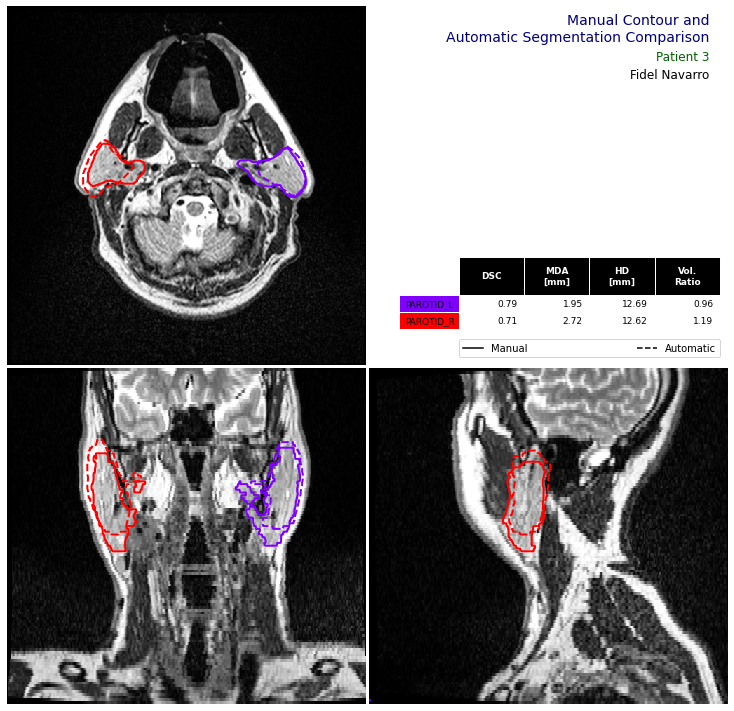

In [90]:
fig = contour_comparison(
    img = img_target,
    contour_dict_a = contours_target,
    contour_dict_b = output_contours,
    contour_label_a='Manual',
    contour_label_b='Automatic',
    title='Manual Contour and\nAutomatic Segmentation Comparison',
    subtitle='\nPatient 3',
    subsubtitle='\nFidel Navarro',
    img_vis_kw=dict(figure_size_in=10, cut=(75,220,150)),
)

#### Briefly describe the performance of the atlas-based segmentation tool for this patient.

From the Dice similarity coefficient (DSC) we have that the automatic segmentation had a value of 0.71 and 0.79 for the right and left parotid respectively. This means that the automatic segmentation has some spatial agreement with the manual contour.

Furthermore, the left parotid has a volume ratio of 0.96 corresponding to a high volume correspondence to the manual contour. Nevertheless, it presents a maximum distance of 12.69 mm from the manual contour and a mean distance of 1.95 mm. These differences in volume are most noticeable on the coronal plane, where the automatic contour is smaller in comparison to the manual. 

On the other hand, the right parotid has a volume ratio of 1.19, a maximum distance of 12.62 mm and a mean distance of 2.72 mm in comparison with the manual contour. The volume difference can be observed on the three planes, where the automatic contour present defined sections outside of the manual contour.


### Question 4

#### With reference to the recent paper:
[Kieselmann et al (2020) Auto-segmentation of the parotid glands on MR images of head and neck cancer patients with deep learning strategies.](https://www.medrxiv.org/content/10.1101/2020.12.19.20248376v1.full-text)
#### Compare the performance of your segmentation to state-of-the-art results. 

The 2D deep learning method presented by Kieselmann et al obtained a DSC of 0.78 amd 0.79, an HD of 12.61 mm and 11.20 mm, and a MSD of 1.79 mm and 1.64 mm for right and left parotid respectively for an independent dataset. In comparison to our segmentation results, the deep learning segmentation obtained a higher accuracy for both right and left parotid. 

#### Would you recommend this tool for use? Why/why not?

Given that our model was trained using the data of two patients it is not adviced its clinical use. For further use this method should be train with a more robust dataset. Following the work of Kieselmann et al, an increase in dataset increases the performance of the method. 

#### What further validation would you suggest?

In order to guarantee that the registration method is efficient and generalazable further training and evaluation using different acquicition modalities and protocols should be used.

# Generating a PDF to submit

To create a PDF:
1. Download this Jupyter notebook (File > Download > Download .ipynb)
2. Upload to you workspace (click the folder icon on the left, drag and drop the .ipynb file)
3. Run the two cells below

In [ ]:
%%capture

!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

In [ ]:
# replace the name with the actual filename!

!jupyter nbconvert --to pdf /content/NAME_OF_YOUR_FILE.ipynb